# Convolutional Neural Networks: Step by Step

이번 과제에서는 컨볼루션 신경망에서 컨볼루션과 풀링을 numpy를 통해 사용해볼겁니다. (순전파와 역전파 또한 포함됩니다!!)


**표기법**:
- 위첨자 $[l]$ 은 신경망의 $l^{th}$ 번째 층을 의미합니다. 
    - 예시: $a^{[4]}$ 는 $4^{th}$ 4번째 활성함수를 의미합니다. $W^{[5]}$와 $b^{[5]}$는 $5^{th}$ 번째 층의 파라미터를 의미합니다.


- 위첨자 $(i)$ 는 $i^{th}$ 번째 데이터의 객체를 의미합니다. 
    - 예시: $x^{(i)}$ 는 입력데이터로 $i^{th}$ 번째 학습 샘플을 의미합니다.
    
    
- 위첨자 $i$ 는  벡터에서 $i^{th}$ 번째 값을 의미합니다.
    - 예시: $a^{[l]}_i$는 $l$번째 활성함수 레이어에서 $i^{th}$번째 데이터를 의미합니다
    
    
- $n_H$, $n_W$ 와 $n_C$ 는 각각 높이 너비 그리고 채널 수를 의미합니다. 만약 층에 대한 정보까지 제공하고 싶다면 $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$ 로 표기합니다. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ 와 $n_{C_{prev}}$ 는 각각 **이전** 층의 높이 너비 채널 수를 의미합니다. 층의 대한 정보는 이전층이니  $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$와 같이 표기합니다. 

## 1 - Packages

필요한 패키지를 호출합니다.  
- [numpy](www.numpy.org) 는 텐서 또는 행렬간의 연산 그리고 다양한 기능을 위해 사용합니다.
- [matplotlib](http://matplotlib.org) 는 시각화를 위해 사용합니다.
- np.random.seed(1) 는 과제 수행중 랜덤한 값을 생성하게 되는데 일정한 값이 나오도록 고정시켜 답과 같은 결과가 나오도록 하는 기능입니다.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - 개요

우리는 컨볼루션 신경망의 각 블럭을 구현할겁니다. 구현해야할 각 기능에 더 세부적인 단계가 있습니다.

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
이번 과제에서는 모든 기능을 `numpy`로 처음부터 구현할겁니다.

다음 과제에서는 tensorflow를 사용해 이번에 구현한 기능을 사용해 아래 사진의 모델을 만들겁니다.

<img src="images/model.png" style="width:800px;height:300px;">

**Note** 
모든 순전파에 대한 역전파를 수행할 예정이기 때문에 순전파로 생긴 매개변수들을 cache에 저장해둬야합니다. 저장된 매개변수들은 역전파에 변화량을 구하는데 사용합니다.

## 3 - Convolutional Neural Networks

비록 프레임워크를 사용하면 컨볼루션을 만들기 쉽지만 딥러닝의 개념을 이해하기 어렵습니다.

한번 직접 공부해 보죠 컨볼루션 레이어는 입력된 사이즈와 출력되는 사이즈가 달라집니다. 아래 그림을 보시죠~

<img src="images/conv_nn.png" style="width:350px;height:200px;">

이제 컨볼루션 층을 만들겁니다.


첫번째로  2개 helper function을 사용할겁니다:
1. zero padding
2. convolution function


### 3.1 - Zero-Padding

Zero-padding은 이미지 주변 테두리에 0을 붙이는 겁니다:

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> RGB 색상 채널을 사용하는 이미지에 padding 2  </center></caption>

패딩을 적용하면 생기는 이점:

- 패딩을 사용하면 CONV 층을 통해 높이와 너비가 줄어들지 않도록 합니다. 이러한 점은 깊은 신경망을 사용할때 점점 사이즈가 줄어들기 때문에 정말 중요하게 작용합니다. 또 다른 중요한 점으로 "same-pooling" 이라는 방법이 있는데 이 전층의 높이와 너비를 정확히 유지시켜줍니다.
    
- 패딩을 사용하면 이미지의 테두리 부분이 갖고있는 정보를 보존할 수 있습니다. 만약 풀링을 사용하지 않는다면 테두리 부분의 정보를 다른 픽셀들에 비해 상대적으로 조금만 사용하는겁니다. 


**Exercise**: 아래 기능은 모든 이미지의 테두리에 0값으로 둘르는 역할을 합니다. [np.pad 를 사용합니다](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) 만약 행렬 a의 구조가 $(5,5,5,5,5)$일때 두번째 차원에 1번 두르고 네번째 차원에 3번 두르고 나머지는 그대로 유지하고 싶다면 다음 코드를 작성하면 됩니다.:  
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
    # mode 와 constatn_values 는 기본값입니다
```


In [6]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


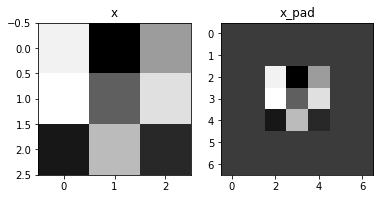

In [9]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)

x_pad = zero_pad(x, 2) # 따로 만든 함수로 2차원(높이) 3차원(너비) 부분에만 패딩을 2칸씩 적용한다는 의미입니다.
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)

print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])
plt.show()

**Expected Output**:

```
x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
```

### 3.2 - Single step of convolution 

이번에는 컨볼루션은 한 단계를 수행해보겠습니다. 
입력된 이미지 중 일부분에 필터를 적용하는 것으로 컨볼루션의 아주 기본적인 역할을 하는 단위가 될겁니다.

- 입력된 이미지에 대한 사이즈를 받습니다.
- 입력된 이미지에 대한 모든 구간에 필터를 적용합니다.
- 출력될 값의 사이즈를 받습니다 (대게 입력과 출력의 사이즈는 다릅니다)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> 필터는 3x3 사이즈이고 필터의 이동 간격을 의미하는 stride 는 1로 잡았습니다.</center></caption>

필터가 입력된 이미지를 지나가면서 겹치는 각 구간은 필터와 편향값으로 계산해 위 사진 처럼 하나의 픽셀로 바뀌게 됩니다. 첫 단계로 필터와 입력이미지의 일부분(1개)으로 1개 픽셀 계산을 수행해보겠습니다. 나중에는 입력되는 값의 모든 부분에 대해 필터와의 연산을 진행할겁니다~~!!

**Exercise**: conv_single_step()를 실행해보세요~. [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).


**Note**:   
변수 b는 하나의 실수 또는 정수로 넘파이 행렬에 넘기면 행렬의 모든 값에 영향을 줍니다.  
만약 넘파이 행렬에 숫자(float or integer)을 더하면 결과는 앞 넘파이 행렬 구조 그대로 나옵니다.   
특별하게 행렬이 1개 값만 갖고있다면 정수나 실수로 변환이 됩니다.

In [12]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)

    return Z

In [13]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


**Expected Output**:
<table>
    <tr>
        <td>
            **Z**
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

### 3.3 - 컨볼루션 신경망의 순전파

순전파에서 입력값에 대해 다양한 필터로 컨볼루션 연산을 수행합니다.

각 'convolution'은 2차원 행렬을 출력으로 나오는데 우리는 출력값들을 합쳐 3차원으로 사용할겁니다:  
<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**Exercise**: 
아래 함수를 통해 입력되는 활성함수 값 `A_prev`에 필터 `W`를 컨볼루션 연산에 사용해보세요~

이 함수에 입력되는 값들은 다음과 같습니다:
* `A_prev`는 이전 층의 활성함수로 나온 출력값입니다.
* 필터의 구조는 `f*f`로 값들은 가중치 또는 기울기로 표현되는 `W`로 구성됩니다. .
* 편향 벡터는 `b`입니다. 각 필터당 1개 값 b가 할당됩니다.

마지막으로 패딩과 스트라이드 정보를 담고 있는 하이퍼파라미터에 접근할 수 있게됐습니다.

**Hint**: 
1. "a_prev" (shape (5,5,3)) 에서 왼쪽 상단에 위치한 구석 부분의 2x2 를 선택하려면:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
3차원 행렬에서 높이2 너비2 채널수 3 짜리 조각을 추출하려면 아래 사진을 참고하면 좋을겁니다. 시작점과 끝점의 인덱스를 잘 생각해보세요~

2. 
조각을 추출하기 위해서는 처음과 끝의 인덱스를 먼저 정의하는게 좋습니다.`vert_start`, `vert_end`, `horiz_start` 그리고 `horiz_end`.   
아래 코드를 보면 좀더 이해하기 쉬울겁니다.


<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **자를 부분의 가로 세로의 각 시작점과 끝점을 정의합니다.** <br> 이 예시는 1개 채널용 모형입니다.  </center></caption>


**Reminder**:
컨볼루션 연산 이후 출력값의 구조를 계산하는 방법은 다음가 같습니다.:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [16]:
# GRADED FUNCTION: conv_forward
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
              numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                   # Select ith training example's padded activation
        for h in range(n_H):                         # loop over vertical axis of the output volume
            for w in range(n_W):                     # loop over horizontal axis of the output volume
                for c in range(n_C):                 # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [18]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4) # (높이 5, 너비 7, 채널 수 4) 10개  : 입력 데이터
W = np.random.randn(3,3,4,8)       # (높이 3, 너비 3, 채널 수 8) : 필터 ==> 입력과 출력이 컨볼루션 연산을 거치면 8개 짜리 데이터가 생깁니다.
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]


**Expected Output**:
```
Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]
```

CONV 층은 나중에 활성함수 까지 거쳐야만 합니다. 미리 간단하게 보여드리자면 다음 코드 처럼 진행합니다:
```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

다음에 직접 해봅시다. 


## 4 - Pooling layer 

풀링 레이어는 높이와 너비를 작게만들어줍니다.

풀링레이어의 이점은 연산량을 줄여줍니다. 그리고 각 위치의 특징을 잡는 역할을 합니다.

풀링 레이어는 대표적으로 2개 형식을 사용합니다:
- Max-pooling layer: 입력된 값에 대해 ($f, f$) 사이즈 윈도우로 훑으면서 각 위치에 최댓값을 저장해 출력합니다.

- Average-pooling layer: 입력된 값에 대해 ($f, f$) 사이즈 윈도우로 훑으면서 각 위치 값들의 평균값을 저장해 출력합니다.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

풀링 레이어는 역전파에 사용할 매개변수가 없습니다. 그러나 하이퍼 파라미터로 윈도우 사이즈 $f$ 가 있습니다.


### 4.1 - Forward Pooling
하나의 함수에서 2개 풀링을 모두 적용해볼겁니다.

**Exercise**: 아래 코드를 기억하면서 풀링레이어를 사용해봅시다.

**Reminder**:
패딩이 적용되지 않았다면 풀링이 적용된 출력값은 다음과 같습니다.

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [20]:
# GRADED FUNCTION: pool_forward
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [21]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

** Expected Output**
```
mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.46210794  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.14472371  0.90159072  2.10025514]
   [ 1.14472371  0.90159072  1.65980218]
   [ 1.14472371  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  0.84616065  1.2245077 ]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.84616065  1.27375593]
   [ 1.96710175  0.84616065  1.23616403]
   [ 1.62765075  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.96710175  0.86888616  1.23616403]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[ -3.01046719e-02  -3.24021315e-03  -3.36298859e-01]
   [  1.43310483e-01   1.93146751e-01  -4.44905196e-01]
   [  1.28934436e-01   2.22428468e-01   1.25067597e-01]]

  [[ -3.81801899e-01   1.59993515e-02   1.70562706e-01]
   [  4.73707165e-02   2.59244658e-02   9.20338402e-02]
   [  3.97048605e-02   1.57189094e-01   3.45302489e-01]]

  [[ -3.82680519e-01   2.32579951e-01   6.25997903e-01]
   [ -2.47157416e-01  -3.48524998e-04   3.50539717e-01]
   [ -9.52551510e-02   2.68511000e-01   4.66056368e-01]]]


 [[[ -1.73134159e-01   3.23771981e-01  -3.43175716e-01]
   [  3.80634669e-02   7.26706274e-02  -2.30268958e-01]
   [  2.03009393e-02   1.41414785e-01  -1.23158476e-02]]

  [[  4.44976963e-01  -2.61694592e-03  -3.10403073e-01]
   [  5.08114737e-01  -2.34937338e-01  -2.39611830e-01]
   [  1.18726772e-01   1.72552294e-01  -2.21121966e-01]]

  [[  4.29449255e-01   8.44699612e-02  -2.72909051e-01]
   [  6.76351685e-01  -1.20138225e-01  -2.44076712e-01]
   [  1.50774518e-01   2.89111751e-01   1.23238536e-03]]]]
```

In [22]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


**Expected Output:**
    
```
mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]
```

이제 전체적인 컨볼루션 신경망을 구성할수 있게 됐습니다

## 5 - 컨볼루션 신경망의 역전파

요즘은 딥러닝 프레임워크로 인해 역전파에 대해 디테일하게 알필요가 없어졌습니다. 
컨볼루션 신경망에서 역전파를 설명하는건 매우 복잡합니다. 코스 초반 부에서 간단한 신경망으로 역전파를 구현해본 경험이 있을겁니다. 비용함수의 결과값에 대해 각 매개변수의 미분값을 구하고 매개변수를 업데이트하는 작업을 해봤습니다. 간단하게 컨볼루션 신경망에서도 비용함수 값에 대해 미분값을 구하고 매개변수를 업데이트하는 일을 합니다.

영상 강의에서는 다루지 않았지만 아래 코드를 보면 간단하게 이해를 할 수 있습니다.


### 5.1 - Convolutional layer backward pass 

컨볼루션 레이어에 대한 역전파!!!

#### 5.1.1 - Computing dA:
아래 수식은 $dA$를 계산하기 위한 수식입니다.  
필터 $W_c$와 입력값의 미분을 사용해 $dA$를 계산합니다.

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$


$W_c$는 필터이고 $dZ_{hw}$는 하나의 스칼라 값입니다.

위 값들로 우리는 dA를 업데이트 하기 위해 필터 $W_c$를 매번 다른 dZ에 곱합니다.

이러한 작업을 하는 이유는 우리가 순전파를 계산할때 필터를 서로 다른 조각에 대해 연산을 했기 때문입니다.

그러므로 역전파로 dA를 구하기 위해 모든 조각에 대한 변화량을 구해야합니다.

코드에서는 반복문이 사용될겁니다 그리고 위 식은 다음과 같이 바뀔겁니다.
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### 5.1.2 - Computing dW:
다음 수식은 $dW_c$ ($dW_c$는 하나의 필터에 대한 미분값입니다.) 를 구하는 방법입니다.

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice.

Since it is the same $W$, we will just add up all such gradients to get $dW$. 

수식을 코드로 바꾸면 다음과 같습니다.:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### 5.1.3 - Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In code, inside the appropriate for-loops, this formula translates into:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

**Exercise**: Implement the `conv_backward` function below. You should sum over all the training examples, filters, heights, and widths. You should then compute the derivatives using formulas 1, 2 and 3 above. 

In [17]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [18]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))


dA_mean = 1.45243777754
dW_mean = 1.72699145831
db_mean = 7.83923256462


** Expected Output: **
<table>
    <tr>
        <td>
            **dA_mean**
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            **dW_mean**
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            **db_mean**
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


## 5.2 Pooling layer - backward pass

다음으로 풀링레이어에 대한 역전파를 수행해보겠습니다. 일단 맥스 풀링을 먼저 실행해보죠~

풀링 레이어는 역전파로 업데이트할 매개변수가 없더라도 이전층의 그레디언트를 계산하기 위해 필요합니다!!

### 5.2.1 Max pooling - backward pass  

풀링레이어에 역전파로 바로 들어가기전에 다음 함수 `create_mask_from_window()`를 선언을 해야합니다.   
$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

보시다시피 이 함수는 "mask" 기능을하는 행렬을 만드는 겁니다. 마스크는 행렬에서 최댓값이 어디에 위치했는지 알려주는 역할을 하죠

True 에 해당하는 값 1을 X 행렬에서 최대값이 있는 위치를 의미하고 나머지 위치는 False (0) 값으로 채워집니다. 나중에 average 풀링 레이어에서 다른 방법의 "mask"를 사용할겁니다. 기대하세요~

**Exercise**: 풀링 레이어에 역전파를 위한 함수 `create_mask_from_window()`를 생성하세요

Hints:
- [np.max()]() 를 사용하면 행렬의 최댓값을 알수 있습니다.
- 행렬 X와 하나의 값인 스칼라 x가 있다면 `A = (X == x)`를 사용해 새로운 행렬 A를 만듭니다. (구조는 X와 같은):
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- 이부분에서는 최댓값이 여러개인 상황에 대해 신경쓰지 않습니다!=.

In [23]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    mask = x == np.max(x)

    return mask

In [24]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


**Expected Output:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
**mask =**
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

왜 최댓값의 위치를 알아야할까요?  
왜냐하면 최댓값이 출력값에 영향을 미쳤고 결과적으로 비용함수에 영향을 미쳤기 때문에 고려해야하기 때문입니다. 역전파는 비용함수 값에 대한 그레디언트를 계산하는 것으로 비용함수에 영향을 끼친 무엇이든 그레디언트가 0이 아니게 됩니다. 그래서 비용함수에 영향을 끼친 모든 것에 그레디언트 값이 존재하게 되고 이렇게 특정한 위치에 있는 값에 대해 그레디언트를 계산해야합니다.  
하지만 최댓값이 아닌 값들은 비용함수에 영향을 안줬기 때문에 모두 0으로 처리하는 겁니다.

### 5.2.2 - Average pooling - backward pass 

맥스 풀링은 각 윈도우에서 최댓값 1개만 비용함수에 영향을 미칩니다.

평균 풀링은 윈도우에 해당하는 모든 요소가 균등하게 영향을 미칩니다.

그래서 역전파를 하기 위해 다른 helper function 을 사용해야합니다.

예를 들어 2x2 필터를 사용한 평균 풀링을 사용했다면 역전파를 위한 마스크 행렬은 다음과 같을 겁니다.:
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

평균을 사용하므로 각 위치의 값들이 비용함수에 균등한 영향을 끼쳤기 때문입니다.

**Exercise**:   
dz 값을 구조에 맞으면서 균등하게 분배하는 함수를 구현합니다. [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [25]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = dz / (n_H * n_W)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = np.ones(shape) * average
    
    return a

In [26]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

### 5.2.3 함수를 하나로 합치기 (Pooling layer backprop)

**Exercise**: 
`pool_backward` 함수로 두가지 풀링 옵션을 다룰 수 있도록 만들어봅시다. 이전과 같이 한번 더 4개 for 문을 사용해야합니다. (데이터 샘플, 높이, 너비, 채널 수) 또 `if/elif`문을 사용해 조건에 맞으면 `max` 또는 `average`를 사용하도록 만듭니다. 만약 'average'가 입력된다면 위에서 만든 `distribute_value()`함수를 사용해야합니다. 반대로 'max'가 입력되면 `create_mask_from_window()`함수를 사용해야합니다.

In [27]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [28]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)



dA_prev = pool_backward(dA, cache, mode = "max")

print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()

dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])


mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>